## Importing Packages

In [1]:
# Importing (using/include) packages and files needed for the code to run 
using SparseArrays
using LinearAlgebra
using IterativeSolvers
using WriteVTK
using Printf
using Statistics 
using Dates
include("Grid.jl")
include("Markers.jl")
include("Stokes.jl")
include("Temperature.jl")
include("GridOperations.jl")

# Note: that we import pyplot last to avoid a name conflict with grid
using PyPlot
include("Visualization.jl")

plots (generic function with 1 method)

# Topography Setup

In [2]:
# The initial topography setup follows the following:
# y = A*sin[k(x-b)]+c 
# |A| is the amplitude 
# k is the wave number (k=2π/wavelength)
# The period is 2π/k 
# The horizontal shift is b 
# The vertical shift is c 


function initial_ice_depth(x::Float64)
    w = 90000.0
#     w1 = 90000.0
#     w2 = 10000.0
#     w3 = 100000.0 
#     w4 = 200000.0
#     w5 = 300000.0
#     w6 = 400000.0
#     w7 = 500000.0
    A = 0.1*90000.0
    k = (2*pi)/w
    b = 0.0
    c = 0.5*90000.0
    return (A)*(sin(k*(x-b)))+(c)
end

function initial_surface_depth(x::Float64)
     return 1e4
end

function ice_viscosity(T::Float64)
    Q = 40000.0 # Activation Enegry (J/mol)
    R_cont = 8.314 # Gas Constant (J/mol*K)
    return (1e15)*exp((Q*(273.0-T))/(R_cont*(273.0*T)))
end


# # Creating a function to assign viscosity if eta is not constant
# function compute_variable_eta(markers::Markers,materials::Materials)
#     t_icy = zeros(1,markers.nmark)
#     eta_i = zeros(1,markers.nmark)
#     for i in 1:markers.nmark
#         mx = markers.x[1,i]
#         my = markers.x[2,i]
#         h = initial_ice_depth(mx)
#         hsurf = initial_surface_depth(mx)
#         if my < h
#             t_icy[i] = 100.0+((273.0-100.0)/(h-hsurf))*(my-hsurf)
#             eta_i[i] = (1e15)*exp((Q*(273.0-t_icy[i]))/(R_cont*(273.0*t_icy[i])))
#         end
#     end 
#     return t_icy,eta_i
# end


ice_viscosity (generic function with 1 method)

# Material Setup

In [3]:
struct Materials
    # 1 - subsurface global ocean
    # 2 - icy shell
    # 3 - sticky air
    alpha::Vector{Float64} # Thermal expansion (1/K)
    rho0::Vector{Float64} # Density (kg/m^3)
    Hr::Vector{Float64} # Radiogenic heat production (W/m^3)
    Cp::Vector{Float64} # Heat capacity (J/kg*K)
    kThermal::Vector{Float64} # Thermal conductivity (W/m*K)
    eta::Vector{Float64} # Viscosity (Pa*s)
    function Materials()
        new([0.0,0.0,0.0],[1000.0,920.0,1.0],[0.0,0.0,0.0],[4180.0,2100.0,1.0],[0.5610,2.22,0.024],[1e12,1e15,1e17])
    end    
end

function update_marker_viscosity!(markers::Markers,materials::Materials)
    eta = markers.scalarFields["eta"]
    T = markers.scalarFields["T"]
    mmat = markers.integers[markers.integerFields["material"],:]
    for i in 1:markers.nmark
        if mmat[i] == 2
            markers.scalars[eta,i] = ice_viscosity( markers.scalars[T,i] )
        end
    end
end


function update_marker_density!(markers::Markers,materials::Materials)
    rho = markers.scalarFields["rho"]
    T = markers.scalarFields["T"]
    mmat = markers.integers[markers.integerFields["material"],:]
    for i in 1:markers.nmark                
        markers.scalars[rho,i] = materials.rho0[mmat[i]]
    end
end


function initial_conditions!(markers::Markers,materials::Materials)
    material = markers.integerFields["material"]
    T = markers.scalarFields["T"]
    eta = markers.scalarFields["eta"]
    alpha = markers.scalarFields["alpha"]
    Cp = markers.scalarFields["Cp"]
    Hr = markers.scalarFields["Hr"]
    
    for i in 1:markers.nmark
        mx = markers.x[1,i]
        my = markers.x[2,i]
        hice = initial_ice_depth(mx)
        hsurf = initial_surface_depth(mx)
        if my > hice
            # subsurface global ocean
            markers.integers[material,i] = 1
            markers.scalars[T,i] = 273.0
            markers.scalars[eta,i] = materials.eta[1]
            markers.scalars[alpha,i] = materials.alpha[1]        
            markers.scalars[Cp,i] = materials.Cp[1]
            markers.scalars[Hr,i] = materials.Hr[1]  
        elseif my > hsurf
            # icy shell
            markers.integers[material,i] = 2
            markers.scalars[T,i] = 100.0+((273.0-100.0)/(hice-hsurf))*(my-hsurf)
            # markers.scalars[eta,i] = eta_i[i]
            markers.scalars[alpha,i] = materials.alpha[2]
            markers.scalars[Cp,i] = materials.Cp[2]
            markers.scalars[Hr,i] = materials.Hr[2]  
        else
            # sticky air
            markers.integers[material,i] = 3
            markers.scalars[T,i] = 100.0            
            markers.scalars[eta,i] = materials.eta[3]
            markers.scalars[alpha,i] = materials.alpha[3]  
            markers.scalars[Cp,i] = materials.Cp[3]
            markers.scalars[Hr,i] = materials.Hr[3] 
        end
    end 
    # end loop over markers
    update_marker_viscosity!(markers,materials)
    update_marker_density!(markers,materials)
end

initial_conditions! (generic function with 1 method)

# Model Setup

In [4]:
# function run(nstep::Int64)
#     nstep=50
    nx = 101
    ny = 101
    W = 90000.0
    H = 90000.0
    gx = 0.0
    gy = 1.3

    
#     Tbctype = [-1,-1,1,1] #left, right, top, bottom
    Tbctype = [1,-1,1,1]
#     Tbcval = [0.0,0.0,100.0,273.0] #left, right, top, bottom
    Tbcval = [273.0,0.0,100.0,273.0]
    bc = BoundaryConditions(0,0,0,0) # currently does nothing but is required argument to stokes solver.
    materials = Materials()
    
    markx = 6
    marky = 6
    seconds_in_year = 3.15e7
    plot_interval = 1e6*seconds_in_year # plot interval in seconds
    end_time = 3e7*seconds_in_year
    dtmax = plot_interval
    grid = CartesianGrid(W,H,nx,ny)
    println("Creating Markers...")
    @time markers = Markers(grid,["alpha","T","rho","eta","Cp","Hr"],["material"] ; nmx=markx,nmy=marky,random=true)
    println("Initial condition...")
    @time initial_conditions!(markers, materials)

    max_time::Float64=1.225e15
    max_step::Int64=-1
    max_time::Float64 = max_time == 1.225e15 ? typemax(Float64) : max_time
    max_step::Int64 = max_step == -1 ? typemax(Int64) : max_step



    # Setting up inital model schematic
    i_air_ice_interface = zeros(Float64,grid.nx+1)
    i_ocean_ice_interface = zeros(Float64,grid.nx+1)
    # Transfer materials to nodes
    i_mat, = marker_to_stag(markers,grid,markers.integers[[markers.integerFields["material"]],:],"center")
    function get_i_interface(grid::CartesianGrid,mat,contour_value)
        i_interface_position = zeros(Float64,grid.nx+1);
        for j in 1:grid.nx+1
            i = 1
            while i <= grid.ny
                if i_mat[i,j] == contour_value
                    i_interface_position[j] = grid.yc[j]
                    break
                elseif i_mat[i+1,j] < contour_value
                    # interface is located within this cell.
                    i_interface_position[j] = grid.yc[i] + (grid.yc[i+1]-grid.yc[i])/(i_mat[i+1,j]-i_mat[i,j])*(contour_value-i_mat[i,j])
                    break
                end
                i = i+1
            end
        end
        return i_interface_position
    end
    i_air_ice_interface = get_i_interface(grid,i_mat,2.5)
    i_ocean_ice_interface = get_i_interface(grid,i_mat,1.5)


    # define arrays for k, rho, cp, H at the basic nodes. Fill them with constant values for now.
    kThermal = 3.0 .*ones(grid.ny,grid.nx);
    
    time = 0.0
    iout=0
    last_plot = 0.0
    dt = 1e10

    rho_c = nothing
    eta_s = nothing
    Hr = nothing
    Cp_c = nothing
    alpha = nothing
    eta_n = nothing
    Tlast = nothing
    rho_vx = nothing 
    rho_vy = nothing
    vxc = nothing 
    vyc = nothing
    dTmax = nothing
    T = nothing 

#     local rho_c 
#     local rho_vx
#     local rho_vy
#     local alpha
#     local Hr
#     local Cp_c
#     local eta_s
#     local eta_n
#     local vxc
#     local vyc
#     local T
#     local dt
#     local dTmax
#     local dTemp
#     local Tnew
#     local Tlast

    itime = 1

    terminate = false
    while !terminate
    output_dir = "test"
#     for itime in 1:nstep
        # 0. update the viscosity and the density on the markers
        update_marker_viscosity!(markers,materials)
        # 1. Transfer properties markers -> nodes
        # 1a. Basic Nodes
        eta_s_new, = marker_to_stag(markers,grid,["eta",],"basic");
        # 1b. Cell Centers
        rho_c_new,Cp_c_new,alpha_new,eta_n_new,Tlast_new,Hr_new = marker_to_stag(markers,grid,["rho","Cp","alpha","eta","T","Hr"],"center")
        # 1c. Vx and Vy nodes:
        rho_vx_new, = marker_to_stag(markers,grid,["rho",],"vx")
        rho_vy_new, = marker_to_stag(markers,grid,["rho",],"vy") 
       
        # deal with any NaN values from interpolation:
        if itime > 1
            if any(isnan.(eta_s_new))
                println("found nan values")
            end
            replace_nan!(eta_s,eta_s_new)
            replace_nan!(rho_c,rho_c_new)
            replace_nan!(Hr,Hr_new)
            replace_nan!(Cp_c,Cp_c_new)
            replace_nan!(alpha,alpha_new)
            replace_nan!(eta_n,eta_n_new)
            replace_nan!(Tlast,Tlast_new)
            replace_nan!(rho_vx,rho_vx_new)
            replace_nan!(rho_vy,rho_vy_new)
        end
        # Copy field data 
        rho_vx = copy(rho_vx_new)
        rho_vy = copy(rho_vy_new)
        rho_c = copy(rho_c_new)
        Hr = copy(Hr_new)
        Cp_c = copy(Cp_c_new)
        alpha = copy(alpha_new)
        eta_s = copy(eta_s_new)
        eta_n = copy(eta_n_new)
        Tlast = copy(Tlast_new)

        # 2. Assemble and solve the stokes equations
        L,R = form_stokes(grid,eta_s,eta_n,rho_vx,rho_vy,bc,gx,gy)
        stokes_solution = L\R
        vx,vy,P = unpack(stokes_solution,grid;ghost=true)
    
        # Get the velocity at the cell centers:
        vxc,vyc = velocity_to_centers(grid,vx,vy)
        adiabatic_heating = compute_adiabatic_heating(grid,rho_c,Tlast,alpha,gx,gy,vxc,vyc)
        shear_heating = compute_shear_heating(grid,vx,vy,eta_n,eta_s)
        H = (adiabatic_heating .+ shear_heating .+ Hr)
    
    
        # 3. Compute the advection timestep:
        if itime > 1
            this_dtmax = min(1.2*dt,dtmax)
        else
            this_dtmax = dtmax
        end
        dt = compute_timestep(grid,vxc,vyc ; dtmax=this_dtmax)
   
        dTmax = Inf
        dTemp = nothing
        Tnew = nothing
        titer = 1
        for titer=1:2
            # assemble and solve the energy equation
            println("Trying with timestep ",dt)
            L,R = assemble_energy_equation_center(grid,rho_c,Cp_c,kThermal,H,Tlast,dt,Tbctype,Tbcval);
            Tnew = L\R;
            Tnew = reshape(Tnew,grid.ny,grid.nx);
            Tnew = ghost_temperature_center(grid,Tnew,Tbctype,Tbcval);

            T = copy(Tnew)

            dTemp = Tnew-Tlast
            # compute the maximum temperature change
#             dTmax = maximum(abs.(dTemp))
            dTmax = maximum(abs.(dTemp[2:end-1,2:end-1]))
            
#             println("dTmax=",dTmax," dt=",dt/3.15e7/1e6)
            dt = min(dt,dTmax < 10.0 ? dt : dt*10.0/dTmax)
            if dTmax < 10.0
                break
            end
        end

        dT_subgrid_node = subgrid_temperature_relaxation_center!(markers,grid,Tlast,Cp_c[1,1],kThermal[1,1],dt)
        dT_remaining = dTemp - dT_subgrid_node
    
        cell_center_change_to_markers!(markers,grid,dT_remaining,"T")
    
        # Checking Termination Criteria, time is in seconds
        if time >= max_time || itime >= max_step
            terminate = true
        end    

        if time == 0.0 || time - last_plot >= plot_interval  || mod(itime,100) == 0
            last_plot = time 
            name = @sprintf("%s/viz.%04d.vtr",output_dir,iout)
            vn = velocity_to_basic_nodes(grid,vxc,vyc)

        visualization(grid,rho_c,eta_s,vn,P,Tnew[2:end-1,2:end-1],time/seconds_in_year;filename=name)
            name = @sprintf("%s/markers.%04d.vtp",output_dir,iout)
            visualization(markers,time/seconds_in_year;filename=name)
            iout += 1
        end
    
#         println("Min velocity: "," ",minimum(vyc))
#         println("Max velocity: "," ",maximum(vyc))
        # Moving the markers and advancing to the next timestep
        move_markers_rk4!(markers,grid,vx,vy,dt,continuity_weight=1/3)
        time += dt
        itime += 1
#         println("Finished Step ",itime," time=",time/seconds_in_year/1e6," Myr")
        println("Finished Step ",itime," time=",time," Seconds")
    end
    return grid,markers,vxc,vyc,rho_c,eta_n,Tnew,time
# end 
# @time grid,markers,vxc,vyc,rho_c,eta_n,Tnew,time = run(1)

figure()
scatter(markers.x[1,:],markers.x[2,:],c="b",s=0.1)
show()

Creating Markers...
  0.144604 seconds (153.89 k allocations: 41.588 MiB, 4.41% gc time, 88.37% compilation time)
Initial condition...
  0.170711 seconds (1.79 M allocations: 31.692 MiB, 3.52% gc time, 46.82% compilation time: 26% of which was recompilation)
  0.003383 seconds (2 allocations: 5.493 MiB)
Finished Step 2 time=6.947936372484987e6 Seconds
Finished Step 3 time=1.0417088005726118e7 Seconds
Finished Step 4 time=1.4580069965615476e7 Seconds
Finished Step 5 time=1.9575648317482706e7 Seconds
Finished Step 6 time=2.5570342339723382e7 Seconds
Finished Step 7 time=3.2763975166412193e7 Seconds
Finished Step 8 time=4.139633455843876e7 Seconds
Finished Step 9 time=5.175516582887065e7 Seconds
Finished Step 10 time=6.4185763353388906e7 Seconds
Finished Step 11 time=7.910248038281082e7 Seconds
Finished Step 12 time=9.700254081811711e7 Seconds
Finished Step 13 time=1.1848261334048466e8 Seconds
Finished Step 14 time=1.4425870036732572e8 Seconds
Finished Step 15 time=1.75190004799535e8 Seco

Finished Step 157 time=2.8109438560643277e9 Seconds
Finished Step 158 time=2.8109438712047215e9 Seconds
Finished Step 159 time=2.8109438857793193e9 Seconds
Finished Step 160 time=2.8109438998314686e9 Seconds
Finished Step 161 time=2.8109439133998795e9 Seconds
Finished Step 162 time=2.810943926519213e9 Seconds
Finished Step 163 time=2.810943939220584e9 Seconds
Finished Step 164 time=2.810943951531993e9 Seconds
Finished Step 165 time=2.810943963478705e9 Seconds
Finished Step 166 time=2.8109439750835667e9 Seconds
Finished Step 167 time=2.8109439863672915e9 Seconds
Finished Step 168 time=2.8109439973487043e9 Seconds
Finished Step 169 time=2.8109440080449495e9 Seconds
Finished Step 170 time=2.810944018471681e9 Seconds
Finished Step 171 time=2.8109440286432214e9 Seconds
Finished Step 172 time=2.810944038572708e9 Seconds
Finished Step 173 time=2.810944048272214e9 Seconds
Finished Step 174 time=2.8109440577528615e9 Seconds
Finished Step 175 time=2.8109440670249166e9 Seconds
Finished Step 176 t

Finished Step 315 time=2.8109446465214286e9 Seconds
Finished Step 316 time=2.8109446485981984e9 Seconds
Finished Step 317 time=2.810944650661692e9 Seconds
Finished Step 318 time=2.8109446527120504e9 Seconds
Finished Step 319 time=2.810944654749404e9 Seconds
Finished Step 320 time=2.8109446567739e9 Seconds
Finished Step 321 time=2.8109446587856636e9 Seconds
Finished Step 322 time=2.8109446607848263e9 Seconds
Finished Step 323 time=2.8109446627715178e9 Seconds
Finished Step 324 time=2.8109446647458634e9 Seconds
Finished Step 325 time=2.81094466670799e9 Seconds
Finished Step 326 time=2.810944668658021e9 Seconds
Finished Step 327 time=2.810944670596077e9 Seconds
Finished Step 328 time=2.8109446725222783e9 Seconds
Finished Step 329 time=2.8109446744367423e9 Seconds
Finished Step 330 time=2.8109446763395867e9 Seconds
Finished Step 331 time=2.8109446782309256e9 Seconds
Finished Step 332 time=2.8109446801108723e9 Seconds
Finished Step 333 time=2.8109446819795375e9 Seconds
Finished Step 334 tim

Finished Step 473 time=2.8109448669338737e9 Seconds
Finished Step 474 time=2.8109448678740864e9 Seconds
Finished Step 475 time=2.8109448688105006e9 Seconds
Finished Step 476 time=2.810944869743146e9 Seconds
Finished Step 477 time=2.8109448706720395e9 Seconds
Finished Step 478 time=2.8109448715972037e9 Seconds
Finished Step 479 time=2.810944872518668e9 Seconds
Finished Step 480 time=2.8109448734364448e9 Seconds
Finished Step 481 time=2.8109448743505683e9 Seconds
Finished Step 482 time=2.8109448752610545e9 Seconds
Finished Step 483 time=2.8109448761679244e9 Seconds
Finished Step 484 time=2.8109448770712004e9 Seconds
Finished Step 485 time=2.810944877970905e9 Seconds
Finished Step 486 time=2.810944878867058e9 Seconds
Finished Step 487 time=2.810944879759682e9 Seconds
Finished Step 488 time=2.810944880648799e9 Seconds
Finished Step 489 time=2.810944881534427e9 Seconds
Finished Step 490 time=2.8109448824165883e9 Seconds
Finished Step 491 time=2.810944883295302e9 Seconds
Finished Step 492 ti

Finished Step 631 time=2.8109449797141585e9 Seconds
Finished Step 632 time=2.8109449802539124e9 Seconds
Finished Step 633 time=2.810944980792006e9 Seconds
Finished Step 634 time=2.8109449813284483e9 Seconds
Finished Step 635 time=2.810944981863242e9 Seconds
Finished Step 636 time=2.8109449823964e9 Seconds
Finished Step 637 time=2.810944982927927e9 Seconds
Finished Step 638 time=2.810944983457833e9 Seconds
Finished Step 639 time=2.8109449839861197e9 Seconds
Finished Step 640 time=2.8109449845128e9 Seconds
Finished Step 641 time=2.8109449850378776e9 Seconds
Finished Step 642 time=2.8109449855613623e9 Seconds
Finished Step 643 time=2.81094498608326e9 Seconds
Finished Step 644 time=2.810944986603577e9 Seconds
Finished Step 645 time=2.8109449871223207e9 Seconds
Finished Step 646 time=2.810944987639498e9 Seconds
Finished Step 647 time=2.8109449881551166e9 Seconds
Finished Step 648 time=2.810944988669182e9 Seconds
Finished Step 649 time=2.8109449891817017e9 Seconds
Finished Step 650 time=2.81

Finished Step 790 time=2.8109450486547647e9 Seconds
Finished Step 791 time=2.810945049001525e9 Seconds
Finished Step 792 time=2.810945049347412e9 Seconds
Finished Step 793 time=2.810945049692426e9 Seconds
Finished Step 794 time=2.8109450500365734e9 Seconds
Finished Step 795 time=2.8109450503798547e9 Seconds
Finished Step 796 time=2.8109450507222743e9 Seconds
Finished Step 797 time=2.8109450510638356e9 Seconds
Finished Step 798 time=2.810945051404538e9 Seconds
Finished Step 799 time=2.8109450517443924e9 Seconds
Finished Step 800 time=2.8109450520833993e9 Seconds
  0.003952 seconds (2 allocations: 5.493 MiB)
Finished Step 801 time=2.8109450524215565e9 Seconds
Finished Step 802 time=2.810945052758867e9 Seconds
Finished Step 803 time=2.8109450530953403e9 Seconds
Finished Step 804 time=2.810945053430978e9 Seconds
Finished Step 805 time=2.8109450537657804e9 Seconds
Finished Step 806 time=2.8109450540997496e9 Seconds
Finished Step 807 time=2.8109450544328933e9 Seconds
Finished Step 808 time=2

Finished Step 948 time=2.8109450943205523e9 Seconds
Finished Step 949 time=2.810945094560518e9 Seconds
Finished Step 950 time=2.810945094799965e9 Seconds
Finished Step 951 time=2.810945095038897e9 Seconds
Finished Step 952 time=2.810945095277315e9 Seconds
Finished Step 953 time=2.8109450955152216e9 Seconds
Finished Step 954 time=2.8109450957526193e9 Seconds
Finished Step 955 time=2.810945095989506e9 Seconds
Finished Step 956 time=2.810945096225885e9 Seconds
Finished Step 957 time=2.810945096461757e9 Seconds
Finished Step 958 time=2.8109450966971273e9 Seconds
Finished Step 959 time=2.810945096931995e9 Seconds
Finished Step 960 time=2.8109450971663613e9 Seconds
Finished Step 961 time=2.8109450974002285e9 Seconds
Finished Step 962 time=2.810945097633598e9 Seconds
Finished Step 963 time=2.8109450978664703e9 Seconds
Finished Step 964 time=2.8109450980988436e9 Seconds
Finished Step 965 time=2.8109450983307295e9 Seconds
Finished Step 966 time=2.8109450985621223e9 Seconds
Finished Step 967 tim

Finished Step 1104 time=2.81094512636056e9 Seconds
Finished Step 1105 time=2.8109451265357504e9 Seconds
Finished Step 1106 time=2.810945126710613e9 Seconds
Finished Step 1107 time=2.8109451268851438e9 Seconds
Finished Step 1108 time=2.810945127059345e9 Seconds
Finished Step 1109 time=2.8109451272332172e9 Seconds
Finished Step 1110 time=2.8109451274067626e9 Seconds
Finished Step 1111 time=2.810945127579952e9 Seconds
Finished Step 1112 time=2.810945127752854e9 Seconds
Finished Step 1113 time=2.810945127925429e9 Seconds
Finished Step 1114 time=2.810945128097661e9 Seconds
Finished Step 1115 time=2.8109451282695894e9 Seconds
Finished Step 1116 time=2.8109451284411926e9 Seconds
Finished Step 1117 time=2.8109451286124725e9 Seconds
Finished Step 1118 time=2.8109451287834325e9 Seconds
Finished Step 1119 time=2.8109451289540696e9 Seconds
Finished Step 1120 time=2.8109451291243863e9 Seconds
Finished Step 1121 time=2.810945129294385e9 Seconds
Finished Step 1122 time=2.810945129464068e9 Seconds
Fin

Finished Step 1260 time=2.810945150164465e9 Seconds
Finished Step 1261 time=2.810945150296879e9 Seconds
Finished Step 1262 time=2.8109451504290733e9 Seconds
Finished Step 1263 time=2.8109451505610414e9 Seconds
Finished Step 1264 time=2.8109451506927853e9 Seconds
Finished Step 1265 time=2.810945150824307e9 Seconds
Finished Step 1266 time=2.8109451509555974e9 Seconds
Finished Step 1267 time=2.8109451510866647e9 Seconds
Finished Step 1268 time=2.810945151217509e9 Seconds
Finished Step 1269 time=2.8109451513481297e9 Seconds
Finished Step 1270 time=2.8109451514785285e9 Seconds
Finished Step 1271 time=2.810945151608705e9 Seconds
Finished Step 1272 time=2.8109451517386603e9 Seconds
Finished Step 1273 time=2.8109451518683944e9 Seconds
Finished Step 1274 time=2.810945151997909e9 Seconds
Finished Step 1275 time=2.810945152127197e9 Seconds
Finished Step 1276 time=2.810945152256268e9 Seconds
Finished Step 1277 time=2.810945152385125e9 Seconds
Finished Step 1278 time=2.810945152513761e9 Seconds
Fin

Finished Step 1415 time=2.8109451682433543e9 Seconds
Finished Step 1416 time=2.810945168345424e9 Seconds
Finished Step 1417 time=2.8109451684473224e9 Seconds
Finished Step 1418 time=2.8109451685490484e9 Seconds
Finished Step 1419 time=2.8109451686505985e9 Seconds
Finished Step 1420 time=2.810945168751983e9 Seconds
Finished Step 1421 time=2.810945168853182e9 Seconds
Finished Step 1422 time=2.8109451689542274e9 Seconds
Finished Step 1423 time=2.810945169055101e9 Seconds
Finished Step 1424 time=2.8109451691558046e9 Seconds
Finished Step 1425 time=2.810945169256334e9 Seconds
Finished Step 1426 time=2.8109451693566914e9 Seconds
Finished Step 1427 time=2.8109451694568796e9 Seconds
Finished Step 1428 time=2.810945169556898e9 Seconds
Finished Step 1429 time=2.810945169656747e9 Seconds
Finished Step 1430 time=2.8109451697564225e9 Seconds
Finished Step 1431 time=2.8109451698559318e9 Seconds
Finished Step 1432 time=2.810945169955274e9 Seconds
Finished Step 1433 time=2.8109451700544443e9 Seconds
F

Finished Step 1571 time=2.810945182154776e9 Seconds
Finished Step 1572 time=2.8109451822308993e9 Seconds
Finished Step 1573 time=2.81094518230685e9 Seconds
Finished Step 1574 time=2.8109451823826256e9 Seconds
Finished Step 1575 time=2.8109451824582267e9 Seconds
Finished Step 1576 time=2.810945182533651e9 Seconds
Finished Step 1577 time=2.8109451826089025e9 Seconds
Finished Step 1578 time=2.810945182683967e9 Seconds
Finished Step 1579 time=2.810945182758869e9 Seconds
Finished Step 1580 time=2.8109451828335958e9 Seconds
Finished Step 1581 time=2.8109451829081445e9 Seconds
Finished Step 1582 time=2.8109451829825172e9 Seconds
Finished Step 1583 time=2.8109451830567117e9 Seconds
Finished Step 1584 time=2.8109451831307287e9 Seconds
Finished Step 1585 time=2.8109451832045684e9 Seconds
Finished Step 1586 time=2.810945183278224e9 Seconds
Finished Step 1587 time=2.8109451833517084e9 Seconds
Finished Step 1588 time=2.8109451834250126e9 Seconds
Finished Step 1589 time=2.8109451834981394e9 Seconds


Finished Step 1726 time=2.810945191526266e9 Seconds
Finished Step 1727 time=2.810945191566987e9 Seconds
Finished Step 1728 time=2.8109451916073775e9 Seconds
Finished Step 1729 time=2.8109451916474357e9 Seconds
Finished Step 1730 time=2.8109451916871595e9 Seconds
Finished Step 1731 time=2.8109451917265472e9 Seconds
Finished Step 1732 time=2.8109451917655973e9 Seconds
Finished Step 1733 time=2.810945191804306e9 Seconds
Finished Step 1734 time=2.8109451918426576e9 Seconds
Finished Step 1735 time=2.810945191880682e9 Seconds
Finished Step 1736 time=2.8109451919183617e9 Seconds
Finished Step 1737 time=2.810945191955686e9 Seconds
Finished Step 1738 time=2.8109451919926605e9 Seconds
Finished Step 1739 time=2.810945192029278e9 Seconds
Finished Step 1740 time=2.810945192065539e9 Seconds
Finished Step 1741 time=2.8109451921014395e9 Seconds
Finished Step 1742 time=2.810945192136979e9 Seconds
Finished Step 1743 time=2.8109451921721563e9 Seconds
Finished Step 1744 time=2.8109451922069674e9 Seconds
F

Finished Step 1882 time=2.8109451943705263e9 Seconds
Finished Step 1883 time=2.8109451945267463e9 Seconds
Finished Step 1884 time=2.81094519471421e9 Seconds
Finished Step 1885 time=2.810945194939167e9 Seconds
Finished Step 1886 time=2.810945195209115e9 Seconds
Finished Step 1887 time=2.810945195533053e9 Seconds
Finished Step 1888 time=2.810945195921778e9 Seconds
Finished Step 1889 time=2.8109451963882484e9 Seconds
Finished Step 1890 time=2.810945196948013e9 Seconds
Finished Step 1891 time=2.81094519761973e9 Seconds
Finished Step 1892 time=2.810945198425791e9 Seconds
Finished Step 1893 time=2.8109451993930635e9 Seconds
Finished Step 1894 time=2.810945200553791e9 Seconds
Finished Step 1895 time=2.810945201946664e9 Seconds
Finished Step 1896 time=2.8109452036181116e9 Seconds
Finished Step 1897 time=2.810945205623849e9 Seconds
Finished Step 1898 time=2.8109452080307336e9 Seconds
Finished Step 1899 time=2.810945210918995e9 Seconds
Finished Step 1900 time=2.8109452143849087e9 Seconds
  0.003

Finished Step 2037 time=2.8109601515195856e9 Seconds
Finished Step 2038 time=2.810960280615219e9 Seconds
Finished Step 2039 time=2.8109604098574104e9 Seconds
Finished Step 2040 time=2.8109605392464733e9 Seconds
Finished Step 2041 time=2.8109606687827234e9 Seconds
Finished Step 2042 time=2.8109607984664764e9 Seconds
Finished Step 2043 time=2.81096092829805e9 Seconds
Finished Step 2044 time=2.810961058277762e9 Seconds
Finished Step 2045 time=2.810961188405932e9 Seconds
Finished Step 2046 time=2.81096131868288e9 Seconds
Finished Step 2047 time=2.810961449108927e9 Seconds
Finished Step 2048 time=2.810961579684395e9 Seconds
Finished Step 2049 time=2.810961710409608e9 Seconds
Finished Step 2050 time=2.8109618412848897e9 Seconds
Finished Step 2051 time=2.8109619723105655e9 Seconds
Finished Step 2052 time=2.810962103486962e9 Seconds
Finished Step 2053 time=2.810962234814406e9 Seconds
Finished Step 2054 time=2.8109623662932262e9 Seconds
Finished Step 2055 time=2.810962497923752e9 Seconds
Finish

Finished Step 2193 time=2.8109737450993404e9 Seconds
Finished Step 2194 time=2.810973750510001e9 Seconds
Finished Step 2195 time=2.8109737508746305e9 Seconds
Finished Step 2196 time=2.8109737513121853e9 Seconds
Finished Step 2197 time=2.810973751837251e9 Seconds
Finished Step 2198 time=2.8109737522601576e9 Seconds
Finished Step 2199 time=2.810973752385686e9 Seconds
Finished Step 2200 time=2.8109737525363197e9 Seconds
  0.003113 seconds (2 allocations: 5.493 MiB)
Finished Step 2201 time=2.8109737527170806e9 Seconds
Finished Step 2202 time=2.810973752781162e9 Seconds
Finished Step 2203 time=2.8109737528580594e9 Seconds
Finished Step 2204 time=2.8109737529503365e9 Seconds
Finished Step 2205 time=2.810973753061069e9 Seconds
Finished Step 2206 time=2.8109737531939483e9 Seconds
Finished Step 2207 time=2.8109737533534036e9 Seconds
Finished Step 2208 time=2.8109737535447497e9 Seconds
Finished Step 2209 time=2.810973753774365e9 Seconds
Finished Step 2210 time=2.8109737540499034e9 Seconds
Finish

Finished Step 2348 time=2.810973808111141e9 Seconds
Finished Step 2349 time=2.810973808833867e9 Seconds
Finished Step 2350 time=2.810973809701138e9 Seconds
Finished Step 2351 time=2.8109738107418633e9 Seconds
Finished Step 2352 time=2.8109738119907336e9 Seconds
Finished Step 2353 time=2.810973813489378e9 Seconds
Finished Step 2354 time=2.810973815287751e9 Seconds
Finished Step 2355 time=2.810973817445799e9 Seconds
Finished Step 2356 time=2.810973820035456e9 Seconds
Finished Step 2357 time=2.810973823143045e9 Seconds
Finished Step 2358 time=2.8109738268721514e9 Seconds
Finished Step 2359 time=2.8109738313470793e9 Seconds
Finished Step 2360 time=2.8109738367169924e9 Seconds
Finished Step 2361 time=2.810973843160888e9 Seconds
Finished Step 2362 time=2.8109738508935633e9 Seconds
Finished Step 2363 time=2.8109738601727734e9 Seconds
Finished Step 2364 time=2.8109738617627964e9 Seconds
Finished Step 2365 time=2.8109738636708245e9 Seconds
Finished Step 2366 time=2.810973865960458e9 Seconds
Fin

Finished Step 2503 time=2.8109746349375787e9 Seconds
Finished Step 2504 time=2.8109746351714954e9 Seconds
Finished Step 2505 time=2.8109746354521956e9 Seconds
Finished Step 2506 time=2.810974635789036e9 Seconds
Finished Step 2507 time=2.810974636193244e9 Seconds
Finished Step 2508 time=2.8109746366782937e9 Seconds
Finished Step 2509 time=2.8109746372603536e9 Seconds
Finished Step 2510 time=2.810974637958825e9 Seconds
Finished Step 2511 time=2.8109746387969913e9 Seconds
Finished Step 2512 time=2.8109746398027906e9 Seconds
Finished Step 2513 time=2.81097464100975e9 Seconds
Finished Step 2514 time=2.810974642458101e9 Seconds
Finished Step 2515 time=2.810974644196122e9 Seconds
Finished Step 2516 time=2.810974646281748e9 Seconds
Finished Step 2517 time=2.810974648784498e9 Seconds
Finished Step 2518 time=2.810974651787799e9 Seconds
Finished Step 2519 time=2.81097465539176e9 Seconds
Finished Step 2520 time=2.8109746597165127e9 Seconds
Finished Step 2521 time=2.810974664906216e9 Seconds
Finish

Finished Step 2659 time=2.81097599692394e9 Seconds
Finished Step 2660 time=2.8109759969978795e9 Seconds
Finished Step 2661 time=2.8109759970866065e9 Seconds
Finished Step 2662 time=2.810975997193079e9 Seconds
Finished Step 2663 time=2.8109759973208456e9 Seconds
Finished Step 2664 time=2.8109759974363503e9 Seconds
Finished Step 2665 time=2.810975997574956e9 Seconds
Finished Step 2666 time=2.810975997615139e9 Seconds
Finished Step 2667 time=2.8109759976633587e9 Seconds
Finished Step 2668 time=2.8109759977212224e9 Seconds
Finished Step 2669 time=2.8109759977906585e9 Seconds
Finished Step 2670 time=2.8109759977970734e9 Seconds
Finished Step 2671 time=2.810975997804771e9 Seconds
Finished Step 2672 time=2.810975997814008e9 Seconds
Finished Step 2673 time=2.8109759978250933e9 Seconds
Finished Step 2674 time=2.810975997838395e9 Seconds
Finished Step 2675 time=2.8109759978543572e9 Seconds
Finished Step 2676 time=2.810975997873512e9 Seconds
Finished Step 2677 time=2.8109759978964972e9 Seconds
Fi

Finished Step 2814 time=2.8109760353880196e9 Seconds
Finished Step 2815 time=2.8109760358525934e9 Seconds
Finished Step 2816 time=2.810976036410082e9 Seconds
Finished Step 2817 time=2.810976037079068e9 Seconds
Finished Step 2818 time=2.8109760378818517e9 Seconds
Finished Step 2819 time=2.8109760388451915e9 Seconds
Finished Step 2820 time=2.8109760400011997e9 Seconds
Finished Step 2821 time=2.810976041388409e9 Seconds
Finished Step 2822 time=2.8109760430530605e9 Seconds
Finished Step 2823 time=2.8109760450506425e9 Seconds
Finished Step 2824 time=2.8109760474477406e9 Seconds
Finished Step 2825 time=2.8109760503242583e9 Seconds
Finished Step 2826 time=2.8109760537760797e9 Seconds
Finished Step 2827 time=2.8109760579182653e9 Seconds
Finished Step 2828 time=2.8109760628888884e9 Seconds
Finished Step 2829 time=2.810976063169085e9 Seconds
Finished Step 2830 time=2.810976063505321e9 Seconds
Finished Step 2831 time=2.8109760639088044e9 Seconds
Finished Step 2832 time=2.8109760639367466e9 Second

Finished Step 2970 time=2.8109762714803333e9 Seconds
Finished Step 2971 time=2.8109762714807796e9 Seconds
Finished Step 2972 time=2.810976271481315e9 Seconds
Finished Step 2973 time=2.810976271481958e9 Seconds
Finished Step 2974 time=2.8109762714827294e9 Seconds
Finished Step 2975 time=2.810976271483655e9 Seconds
Finished Step 2976 time=2.8109762714847655e9 Seconds
Finished Step 2977 time=2.8109762714860983e9 Seconds
Finished Step 2978 time=2.8109762714876976e9 Seconds
Finished Step 2979 time=2.810976271489617e9 Seconds
Finished Step 2980 time=2.81097627149192e9 Seconds
Finished Step 2981 time=2.8109762714946837e9 Seconds
Finished Step 2982 time=2.810976271498e9 Seconds
Finished Step 2983 time=2.81097627150198e9 Seconds
Finished Step 2984 time=2.8109762715067554e9 Seconds
Finished Step 2985 time=2.810976271512486e9 Seconds
Finished Step 2986 time=2.810976271519363e9 Seconds
Finished Step 2987 time=2.810976271527615e9 Seconds
Finished Step 2988 time=2.810976271537518e9 Seconds
Finished 

Finished Step 3125 time=2.8109765501554217e9 Seconds
Finished Step 3126 time=2.8109765544842744e9 Seconds
Finished Step 3127 time=2.8109765596788974e9 Seconds
Finished Step 3128 time=2.810976565912445e9 Seconds
Finished Step 3129 time=2.8109765733927026e9 Seconds
Finished Step 3130 time=2.8109765823690114e9 Seconds
Finished Step 3131 time=2.8109765901206446e9 Seconds
Finished Step 3132 time=2.810976590141851e9 Seconds
Finished Step 3133 time=2.810976590167299e9 Seconds
Finished Step 3134 time=2.810976590197836e9 Seconds
Finished Step 3135 time=2.810976590234481e9 Seconds
Finished Step 3136 time=2.810976590278455e9 Seconds
Finished Step 3137 time=2.8109765903312235e9 Seconds
Finished Step 3138 time=2.8109765903945456e9 Seconds
Finished Step 3139 time=2.810976590470532e9 Seconds
Finished Step 3140 time=2.810976590561716e9 Seconds
Finished Step 3141 time=2.810976590671137e9 Seconds
Finished Step 3142 time=2.8109765908024416e9 Seconds
Finished Step 3143 time=2.8109765909600077e9 Seconds
Fi

Finished Step 3281 time=2.810976684846363e9 Seconds
Finished Step 3282 time=2.810976684846393e9 Seconds
Finished Step 3283 time=2.8109766848464293e9 Seconds
Finished Step 3284 time=2.8109766848464727e9 Seconds
Finished Step 3285 time=2.8109766848465247e9 Seconds
Finished Step 3286 time=2.810976684846587e9 Seconds
Finished Step 3287 time=2.810976684846662e9 Seconds
Finished Step 3288 time=2.810976684846752e9 Seconds
Finished Step 3289 time=2.81097668484686e9 Seconds
Finished Step 3290 time=2.8109766848469896e9 Seconds
Finished Step 3291 time=2.810976684847145e9 Seconds
Finished Step 3292 time=2.8109766848473315e9 Seconds
Finished Step 3293 time=2.810976684847555e9 Seconds
Finished Step 3294 time=2.8109766848478236e9 Seconds
Finished Step 3295 time=2.810976684848146e9 Seconds
Finished Step 3296 time=2.8109766848485327e9 Seconds
Finished Step 3297 time=2.8109766848489966e9 Seconds
Finished Step 3298 time=2.8109766848495536e9 Seconds
Finished Step 3299 time=2.8109766848502216e9 Seconds
Fin

Finished Step 3436 time=2.8109766972884784e9 Seconds
Finished Step 3437 time=2.810976697422015e9 Seconds
Finished Step 3438 time=2.8109766975822597e9 Seconds
Finished Step 3439 time=2.810976697774553e9 Seconds
Finished Step 3440 time=2.8109766980053043e9 Seconds
Finished Step 3441 time=2.8109766982822065e9 Seconds
Finished Step 3442 time=2.810976698614489e9 Seconds
Finished Step 3443 time=2.810976698696725e9 Seconds
Finished Step 3444 time=2.810976698795408e9 Seconds
Finished Step 3445 time=2.810976698913827e9 Seconds
Finished Step 3446 time=2.81097669905593e9 Seconds
Finished Step 3447 time=2.810976699226454e9 Seconds
Finished Step 3448 time=2.8109766994310822e9 Seconds
Finished Step 3449 time=2.8109766996766367e9 Seconds
Finished Step 3450 time=2.810976699971302e9 Seconds
Finished Step 3451 time=2.8109767003249e9 Seconds
Finished Step 3452 time=2.810976700749218e9 Seconds
Finished Step 3453 time=2.8109767012583995e9 Seconds
Finished Step 3454 time=2.810976701869417e9 Seconds
Finished

Finished Step 3592 time=2.8109767936273584e9 Seconds
Finished Step 3593 time=2.810976793635948e9 Seconds
Finished Step 3594 time=2.810976793646256e9 Seconds
Finished Step 3595 time=2.810976793658625e9 Seconds
Finished Step 3596 time=2.810976793673468e9 Seconds
Finished Step 3597 time=2.81097679369128e9 Seconds
Finished Step 3598 time=2.810976793712654e9 Seconds
Finished Step 3599 time=2.810976793738303e9 Seconds
Finished Step 3600 time=2.8109767937383084e9 Seconds
  0.003179 seconds (2 allocations: 5.493 MiB)
Finished Step 3601 time=2.8109767937383146e9 Seconds
Finished Step 3602 time=2.8109767937383223e9 Seconds
Finished Step 3603 time=2.8109767937383313e9 Seconds
Finished Step 3604 time=2.8109767937383423e9 Seconds
Finished Step 3605 time=2.810976793738355e9 Seconds
Finished Step 3606 time=2.810976793738371e9 Seconds
Finished Step 3607 time=2.8109767937383895e9 Seconds
Finished Step 3608 time=2.810976793738412e9 Seconds
Finished Step 3609 time=2.810976793738439e9 Seconds
Finished Ste

Finished Step 3747 time=2.8109768049524336e9 Seconds
Finished Step 3748 time=2.810976805267895e9 Seconds
Finished Step 3749 time=2.810976805646449e9 Seconds
Finished Step 3750 time=2.8109768061007137e9 Seconds
Finished Step 3751 time=2.8109768062138944e9 Seconds
Finished Step 3752 time=2.810976806349711e9 Seconds
Finished Step 3753 time=2.8109768065126905e9 Seconds
Finished Step 3754 time=2.8109768067082663e9 Seconds
Finished Step 3755 time=2.8109768069429574e9 Seconds
Finished Step 3756 time=2.8109768072245865e9 Seconds
Finished Step 3757 time=2.8109768075625415e9 Seconds
Finished Step 3758 time=2.810976807968087e9 Seconds
Finished Step 3759 time=2.8109768079688344e9 Seconds
Finished Step 3760 time=2.810976807969731e9 Seconds
Finished Step 3761 time=2.8109768079708066e9 Seconds
Finished Step 3762 time=2.810976807972098e9 Seconds
Finished Step 3763 time=2.8109768079733286e9 Seconds
Finished Step 3764 time=2.8109768079748054e9 Seconds
Finished Step 3765 time=2.8109768079765773e9 Seconds

Finished Step 3902 time=2.810977340778885e9 Seconds
Finished Step 3903 time=2.8109774468281946e9 Seconds
Finished Step 3904 time=2.810977574087366e9 Seconds
Finished Step 3905 time=2.8109777256076713e9 Seconds
Finished Step 3906 time=2.810977877324573e9 Seconds
Finished Step 3907 time=2.8109780292376733e9 Seconds
Finished Step 3908 time=2.8109781813468175e9 Seconds
Finished Step 3909 time=2.8109783336521673e9 Seconds
Finished Step 3910 time=2.81097848615397e9 Seconds
Finished Step 3911 time=2.8109786388525424e9 Seconds
Finished Step 3912 time=2.8109787917482605e9 Seconds
Finished Step 3913 time=2.8109789448415313e9 Seconds
Finished Step 3914 time=2.810979098132788e9 Seconds
Finished Step 3915 time=2.810979251622472e9 Seconds
Finished Step 3916 time=2.8109794053127923e9 Seconds
Finished Step 3917 time=2.810979559200857e9 Seconds
Finished Step 3918 time=2.8109797132890663e9 Seconds
Finished Step 3919 time=2.810979867580208e9 Seconds
Finished Step 3920 time=2.8109800220694823e9 Seconds
Fi

Finished Step 4058 time=2.8109811093250933e9 Seconds
Finished Step 4059 time=2.8109811093251176e9 Seconds
Finished Step 4060 time=2.8109811093251467e9 Seconds
Finished Step 4061 time=2.8109811093251815e9 Seconds
Finished Step 4062 time=2.810981109325223e9 Seconds
Finished Step 4063 time=2.810981109325273e9 Seconds
Finished Step 4064 time=2.810981109325333e9 Seconds
Finished Step 4065 time=2.810981109325405e9 Seconds
Finished Step 4066 time=2.8109811093254914e9 Seconds
Finished Step 4067 time=2.810981109325595e9 Seconds
Finished Step 4068 time=2.810981109325677e9 Seconds
Finished Step 4069 time=2.8109811093257756e9 Seconds
Finished Step 4070 time=2.810981109325894e9 Seconds
Finished Step 4071 time=2.810981109325894e9 Seconds
Finished Step 4072 time=2.810981109325894e9 Seconds
Finished Step 4073 time=2.810981109325894e9 Seconds
Finished Step 4074 time=2.810981109325894e9 Seconds
Finished Step 4075 time=2.810981109325894e9 Seconds
Finished Step 4076 time=2.8109811093258944e9 Seconds
Finis

Finished Step 4213 time=2.810981109355545e9 Seconds
Finished Step 4214 time=2.8109811093556156e9 Seconds
Finished Step 4215 time=2.8109811093557005e9 Seconds
Finished Step 4216 time=2.810981109355802e9 Seconds
Finished Step 4217 time=2.810981109355924e9 Seconds
Finished Step 4218 time=2.8109811093560705e9 Seconds
Finished Step 4219 time=2.810981109356246e9 Seconds
Finished Step 4220 time=2.8109811093563766e9 Seconds
Finished Step 4221 time=2.810981109356533e9 Seconds
Finished Step 4222 time=2.810981109356721e9 Seconds
Finished Step 4223 time=2.8109811093569465e9 Seconds
Finished Step 4224 time=2.810981109357217e9 Seconds
Finished Step 4225 time=2.8109811093575416e9 Seconds
Finished Step 4226 time=2.810981109357931e9 Seconds
Finished Step 4227 time=2.8109811093583984e9 Seconds
Finished Step 4228 time=2.810981109358959e9 Seconds
Finished Step 4229 time=2.8109811093596325e9 Seconds
Finished Step 4230 time=2.810981109360331e9 Seconds
Finished Step 4231 time=2.810981109360361e9 Seconds
Fini

Finished Step 4369 time=2.810981761500256e9 Seconds
Finished Step 4370 time=2.8109818792233405e9 Seconds
Finished Step 4371 time=2.810982020491042e9 Seconds
Finished Step 4372 time=2.8109821782637014e9 Seconds
Finished Step 4373 time=2.8109823362468834e9 Seconds
Finished Step 4374 time=2.810982494441784e9 Seconds
Finished Step 4375 time=2.810982652846153e9 Seconds
Finished Step 4376 time=2.8109828114604387e9 Seconds
Finished Step 4377 time=2.8109829702850924e9 Seconds
Finished Step 4378 time=2.810983129320577e9 Seconds
Finished Step 4379 time=2.810983288567374e9 Seconds
Finished Step 4380 time=2.810983448025961e9 Seconds
Finished Step 4381 time=2.8109834676925635e9 Seconds
Finished Step 4382 time=2.8109834912924867e9 Seconds
Finished Step 4383 time=2.8109835196123943e9 Seconds
Finished Step 4384 time=2.810983553596284e9 Seconds
Finished Step 4385 time=2.810983594376951e9 Seconds
Finished Step 4386 time=2.810983643313752e9 Seconds
Finished Step 4387 time=2.810983702037913e9 Seconds
Fini

Finished Step 4524 time=2.81098743997288e9 Seconds
Finished Step 4525 time=2.8109874399728804e9 Seconds
Finished Step 4526 time=2.810987439972881e9 Seconds
Finished Step 4527 time=2.8109874399728813e9 Seconds
Finished Step 4528 time=2.8109874399728823e9 Seconds
Finished Step 4529 time=2.810987439972883e9 Seconds
Finished Step 4530 time=2.810987439972884e9 Seconds
Finished Step 4531 time=2.8109874399728856e9 Seconds
Finished Step 4532 time=2.810987439972887e9 Seconds
Finished Step 4533 time=2.810987439972889e9 Seconds
Finished Step 4534 time=2.8109874399728913e9 Seconds
Finished Step 4535 time=2.810987439972894e9 Seconds
Finished Step 4536 time=2.8109874399728975e9 Seconds
Finished Step 4537 time=2.8109874399729013e9 Seconds
Finished Step 4538 time=2.810987439972906e9 Seconds
Finished Step 4539 time=2.810987439972912e9 Seconds
Finished Step 4540 time=2.8109874399729185e9 Seconds
Finished Step 4541 time=2.8109874399729266e9 Seconds
Finished Step 4542 time=2.810987439972936e9 Seconds
Fini

LoadError: SingularException(0)

# Plotting Routine 

In [6]:
# # Setting up route for saving plots to a folder
# function mk_output_dir()
#     timestamp = Dates.format(now(), "YYYYmmdd-HHMMSS")
#     dir_name = joinpath(@__DIR__, "Data", "run_$timestamp")
#     @assert !ispath(dir_name) 
#     mkpath(dir_name)
#     return dir_name
# end

mk_output_dir (generic function with 1 method)

# Initial Model Schematic and Profiles

The maximum total initial thickness of the icy shell is 44.1(km)
The average initial thickness of the icy shell is 35(km)
The initial amplitude is 9.03(km)

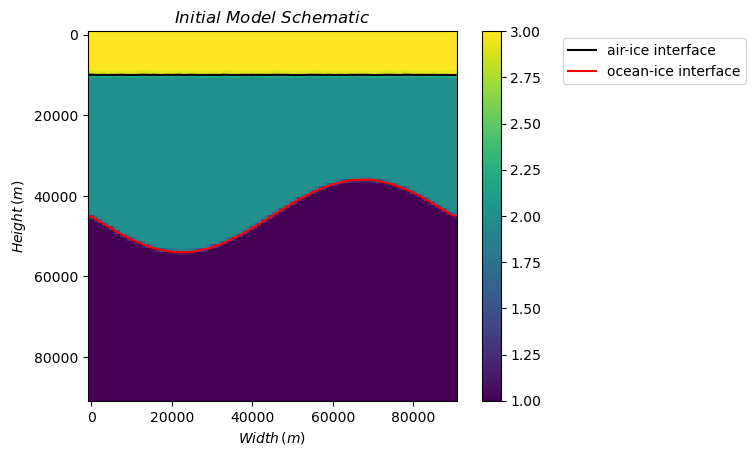

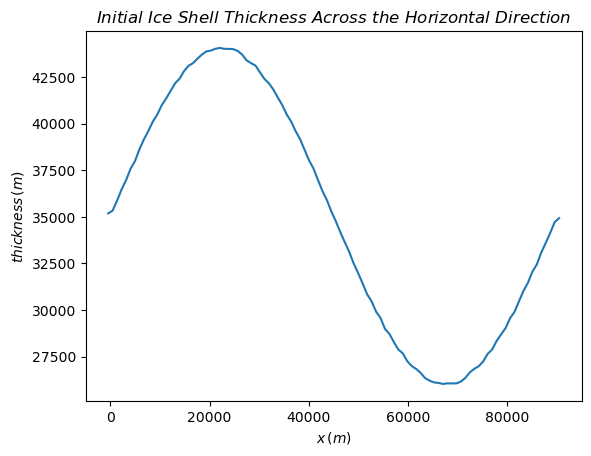

In [8]:
figure() 
pcolor(grid.xc,grid.yc,i_mat)
colorbar()
plot(grid.xc,i_air_ice_interface,"k",label="air-ice interface")
plot(grid.xc,i_ocean_ice_interface,"r",label="ocean-ice interface")
title(L"Initial\,\,Model\,\,Schematic")
filename = "Initial Model Schematic"
gca().invert_yaxis()
gca().set_aspect("equal")
gca().set_ylabel(L"Height\,(m)")
gca().set_xlabel(L"Width\,(m)")
legend(loc="upper right",bbox_to_anchor=[1.8,1.0])
# savefig(mk_output_dir()*"/$filename.pdf")

figure() 
plot(grid.xc,i_ocean_ice_interface-i_air_ice_interface)
title(L"Initial\,\,Ice\,\,Shell\,\,Thickness\,\,Across\,\,the\,\,Horizontal\,\,Direction")
gca().set_ylabel(L"thickness\,(m)")
gca().set_xlabel(L"x\,(m)")


println("The maximum total initial thickness of the icy shell is ",@sprintf("%.3g",maximum(i_ocean_ice_interface-i_air_ice_interface)/1000),"(km)")
i_ice_avg = mean(i_ocean_ice_interface-i_air_ice_interface)
println("The average initial thickness of the icy shell is ",@sprintf("%.3g",i_ice_avg/1000),"(km)")
i_amp = (maximum(i_ocean_ice_interface-i_air_ice_interface)-i_ice_avg)
print("The initial amplitude is ",@sprintf("%.3g",i_amp/1000),"(km)")



# Model Schematic After x Runs 

In [ ]:
air_ice_interface = zeros(Float64,grid.nx+1)
ocean_ice_interface = zeros(Float64,grid.nx+1)

# Transfer materials to nodes
mat, = marker_to_stag(markers,grid,markers.integers[[markers.integerFields["material"]],:],"center")

function get_interface(grid::CartesianGrid,mat,contour_value)
    interface_position = zeros(Float64,grid.nx+1);
    for j in 1:grid.nx+1
        i = 1
        while i <= grid.ny
            if mat[i,j] == contour_value
                interface_position[j] = grid.yc[i]
                break
        elseif mat[i+1,j] < contour_value
                # interface is located within this cell.
                interface_position[j] = grid.yc[i] + (grid.yc[i+1]-grid.yc[i])/(mat[i+1,j]-mat[i,j])*(contour_value-mat[i,j])
                break
            end
            i = i+1
        end
    end
    return interface_position
end
ocean_ice_interface = get_interface(grid,mat,1.5)
air_ice_interface = get_interface(grid,mat,2.5)

x_time = @sprintf("%.3g",time/3.15e7/1e6)
filename = "Model Schematic after $time"
figure()
pcolor(grid.xc,grid.yc,mat)
colorbar()
plot(grid.xc,air_ice_interface,"k",label="air-ice interface")
plot(grid.xc,ocean_ice_interface,"r",label="ocean-ice interface")
title(L"Model\,\,Schematic\,\,at\,\,%$x_time\,Myr")
gca().invert_yaxis()
gca().set_aspect("equal")
gca().set_ylabel(L"Height\,(m)")
gca().set_xlabel(L"Width\,(m)")
legend(loc="upper right",bbox_to_anchor=[1.8,1.0])
show()

figure()
plot(grid.xc,ocean_ice_interface-air_ice_interface)
title(L"Ice\,\,Shell\,\,Thickness\,\,Across\,\,the\,\,Horizontal\,\,Direction\,\,at\,\,%$x_time\,Myr")
gca().set_ylabel(L"thickness\,(m)")
gca().set_xlabel(L"x\,(m)")
show()

println("The maximum total thickness of the icy shell after $x_time Myr is ",@sprintf("%.3g",maximum(ocean_ice_interface-air_ice_interface)/1000),"(km)")
ice_avg = mean(ocean_ice_interface-air_ice_interface)
println("The average thickness of the icy shell after $x_time Myr is ",@sprintf("%.3g",ice_avg/1000),"(km)")
amp = (maximum(ocean_ice_interface-air_ice_interface)-ice_avg)
print("The amplitude after $x_time Myr is ",@sprintf("%.3g",amp/1000),"(km)")

# Plot of Profiles After x Runs

In [ ]:
# Temperature Profile 
figure()
scatter(markers.x[1,:],markers.x[2,:],c=markers.scalars[markers.scalarFields["T"],:],s=0.1)
plot(grid.xc,air_ice_interface,"k",label="air-ice interface")
plot(grid.xc,ocean_ice_interface,"r",label="ocean-ice interface")
title(L"Temperature\,\,Profile\,\,at\,\,%$x_time\,Myr")
colorbar(label=L"K")
gca().invert_yaxis()
gca().set_aspect("equal")
gca().set_ylabel(L"Height\,(m)")
gca().set_xlabel(L"Width\,(m)")
legend(loc="upper right",bbox_to_anchor=[1.8,1.0])
show()

# Viscosity Profile 
figure()
scatter(markers.x[1,:],markers.x[2,:],c=log10.(markers.scalars[markers.scalarFields["eta"],:]),s=0.1)
plot(grid.xc,air_ice_interface,"k",label="air-ice interface")
plot(grid.xc,ocean_ice_interface,"r",label="ocean-ice interface")
title(L"Viscosity\,\,Profile\,\,at\,\,%$x_time\,Myr")
colorbar(label=L"Pa\cdot{s}")
gca().invert_yaxis()
gca().set_aspect("equal")
gca().set_ylabel(L"Height\,(m)")
gca().set_xlabel(L"Width\,(m)")
legend(loc="upper right",bbox_to_anchor=[1.8,1.0])
show()


In [ ]:
t = time/3.15e7/1e6 # Myr
tr = -(t)/log(amp/i_amp)
print(@sprintf("%.3g",tr),"(Myr)")


In [ ]:
# 1. Ran numerical experiments for 30 timesteps at nx = 101 and ny = 101 and wavelengths were 90km,10km,100km,200km,300km 
# 2. Ran numerical experiments for 30 timesteps at nx = 201 and ny = 201 and wavelengths were 10km, 15km, 30km, 45km, 60km
#[experiment_1,experiment_2,experiment_3,experiment_4,experiment_5]

# 1.
# units of Myr
exp1_x_tr1 = 0.00721
exp1_x_tr2 = 0.0267
exp1_x_tr3 = 0.0277
exp1_x_tr4 = 0.0533
exp1_x_tr5 = 0.0581
exp1_x_tr6 = 0.0715
exp1_x_tr7 = 0.0885


# units of km 
exp1_y_w1 = 10
exp1_y_w2 = 90
exp1_y_w3 = 100
exp1_y_w4 = 200
exp1_y_w5 = 300
exp1_y_w6 = 400
exp1_y_w7 = 500

figure()
plot(exp1_x_tr1,exp1_y_w1,"o",label=L"\lambda\,=\,90\,(km)")
plot(exp1_x_tr2,exp1_y_w2,"o",label=L"\lambda\,=\,10\,(km)")
plot(exp1_x_tr3,exp1_y_w3,"o",label=L"\lambda\,=\,100\,(km)")
plot(exp1_x_tr4,exp1_y_w4,"o",label=L"\lambda\,=\,200\,(km)")
plot(exp1_x_tr5,exp1_y_w5,"o",label=L"\lambda\,=\,300\,(km)")
plot(exp1_x_tr6,exp1_y_w6,"o",label=L"\lambda\,=\,400\,(km)")
plot(exp1_x_tr7,exp1_y_w7,"o",label=L"\lambda\,=\,500\,(km)")
gca().set_ylabel(L"\lambda\,(km)")
gca().set_xlabel(L"time\,(Myr)")
title(L"Relaxation\,\,Timescale\,\,vs.\,\,Initital\,\,Topographic\,\,Wavelength\,\,Experiment\,1")
legend(loc="upper right",bbox_to_anchor=[1.8,1.0])
show()


# 2. 
# units of Myr 
exp2_x_tr1 = 0.00939
exp2_x_tr2 = 0.0127
exp2_x_tr3 = 0.013
exp2_x_tr4 = 0.0195
exp2_x_tr5 = 0.0256
exp2_x_tr6 = 0.0323
exp2_x_tr7 = 0.04

# units of km 
exp2_y_w1 = 10
exp2_y_w2 = 90
exp2_y_w3 = 100
exp2_y_w4 = 200
exp2_y_w5 = 300
exp2_y_w6 = 400
exp2_y_w7 = 500

figure()
plot(exp2_x_tr1,exp2_y_w1,"o",label=L"\lambda\,=\,10\,(km)")
plot(exp2_x_tr2,exp2_y_w2,"o",label=L"\lambda\,=\,90\,(km)")
plot(exp2_x_tr3,exp2_y_w3,"o",label=L"\lambda\,=\,100\,(km)")
plot(exp2_x_tr4,exp2_y_w4,"o",label=L"\lambda\,=\,200\,(km)")
plot(exp2_x_tr5,exp2_y_w5,"o",label=L"\lambda\,=\,300\,(km)")
plot(exp2_x_tr6,exp2_y_w6,"o",label=L"\lambda\,=\,400\,(km)")
plot(exp2_x_tr7,exp2_y_w7,"o",label=L"\lambda\,=\,500\,(km)")
gca().set_ylabel(L"\lambda\,(km)")
gca().set_xlabel(L"time\,(Myr)")
title(L"Relaxation\,\,Timescale\,\,vs.\,\,Initital\,\,Topographic\,\,Wavelength\,\,Experiment\,2")
legend(loc="upper right",bbox_to_anchor=[1.8,1.0])
show()

# Printing Values 

In [ ]:
# print("Creating eta at cell center matrix...")
# @time display(eta_n)
# print("Creating vx matrix...")
# @time display(vxc)
# print("Creating vy matrix...")
# @time display(vyc)
# print("Creating rho matrix...")
# @time display(rho_c)

In [ ]:
((9000)^2/(10^-6))/(3.15e7)